In [13]:
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from skimage.filters import threshold_multiotsu
import os
import porespy as ps
from tifffile import imwrite
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
import torch
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
import os
import torch
from cpgan.ooppnm import pnm_sim_old
import statistics as stats



def load_data(ct_idx, vol_dim, root_dir):
    file_path = f'{root_dir}/sample_{ct_idx}/img_gen_vol_{vol_dim}.pkl'
    with open(file_path, 'rb') as file:
        img_results = pickle.load(file)
    return img_results

def extract_phi(img,volume_dimension):
    # segment images into 64^3 cubic voxels in 2*2*2 spatial grid
    extract_phi = []
    for i in range(volume_dimension):
        for j in range(volume_dimension):
            for k in range(volume_dimension):
                subset_image = img[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64]
                porosity = ps.metrics.porosity(subset_image)
                extract_phi.append(porosity)
    return extract_phi





def statistical_summary(data):
    """
    Returns a statistical summary of the input list.
    
    Parameters:
        data (list): A list of numerical values.
        
    Returns:
        dict: A dictionary containing the statistical summary.
    """
    # Check if the input list is empty
    if not data:
        return {
            "mean": None,
            "median": None,
            "variance": None,
            "standard_deviation": None,
            "min": None,
            "max": None,
            "count": 0
        }

    summary = {
        "mean": stats.mean(data),
        "median": stats.median(data),
        "variance": stats.variance(data) if len(data) > 1 else 0,  # Handle single-element variance case
        "standard_deviation": stats.stdev(data) if len(data) > 1 else 0,  # Handle single-element stdev case
        "min": min(data),
        "max": max(data),
        "count": len(data)
    }

    return summary

In [2]:
volume_dim = 6
root_dir = 'db'

ct_idx = 0
img_data_0 = load_data(ct_idx, volume_dim, root_dir)

ct_idx = 1
img_data_1 = load_data(ct_idx, volume_dim, root_dir)

In [14]:
sample_idx = 4
img_0 = img_data_0[sample_idx]['original']
phi_0 = extract_phi(img_0, volume_dim)

img_1 = img_data_1[sample_idx]['original']
phi_1 = extract_phi(img_1, volume_dim)


stats_0 = statistical_summary(phi_0)
stats_1 = statistical_summary(phi_1)

print(stats_0) # lower phi
print(stats_1) # higher phi


{'mean': 0.15907956935741283, 'median': 0.1467132568359375, 'variance': 0.005974873578105199, 'standard_deviation': 0.0772973064091188, 'min': 0.0055999755859375, 'max': 0.4561500549316406, 'count': 216}
{'mean': 0.20841437798959236, 'median': 0.1925678253173828, 'variance': 0.009269944127006215, 'standard_deviation': 0.09628054905849995, 'min': 0.008853912353515625, 'max': 0.6492424011230469, 'count': 216}


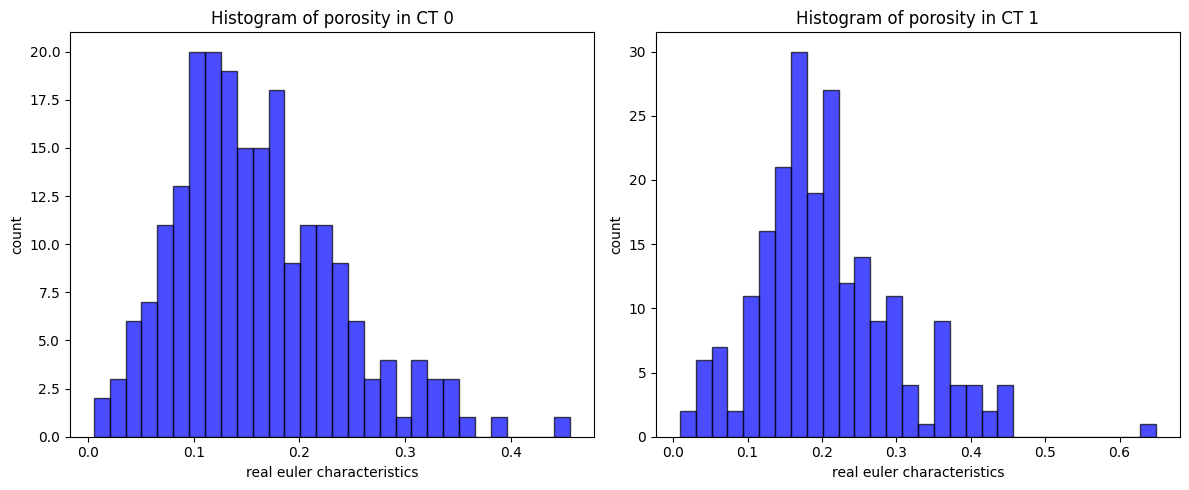

In [15]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram
ax[0].hist(phi_0, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[0].set_xlabel('real euler characteristics')
ax[0].set_ylabel('count')
ax[0].set_title('Histogram of porosity in CT 0')


ax[1].hist(phi_1, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[1].set_xlabel('real euler characteristics')
ax[1].set_ylabel('count')
ax[1].set_title('Histogram of porosity in CT 1')

# Display the figure with the histograms
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()